<a href="https://colab.research.google.com/github/run-llama/llama_parse/blob/main/examples/excel/o1_excel_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How RAG works**

Image Source - (https://www.deeplearning.ai/)
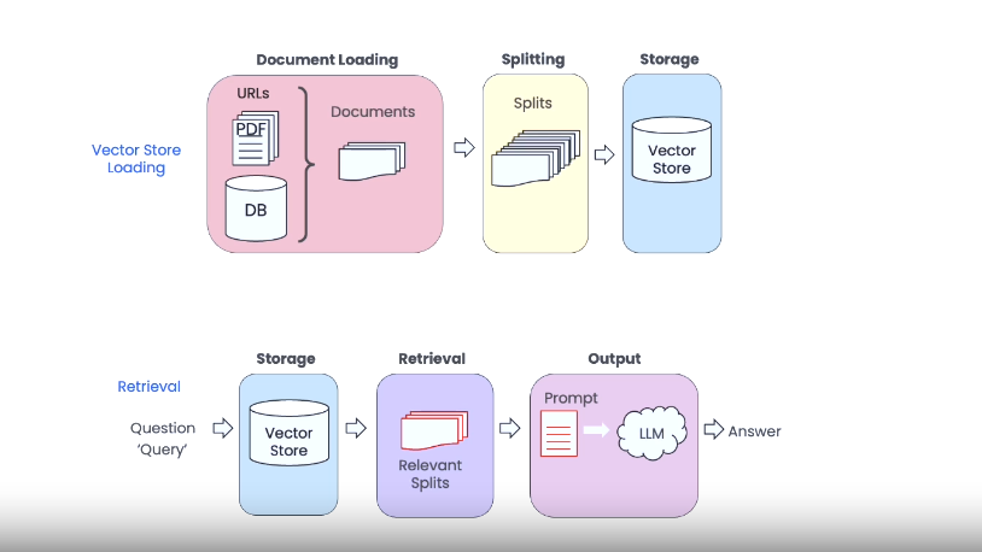

# Advanced RAG with LlamaParse + OpenAI GPT4-o on Excel

This notebook provides a reference to compare advanced RAG capabilities using LlamaParse and Recursive Retrieval with `o1-preview`, `o1-mini` and `gpt4o-mini` on a sample Excel document.

We will use the [`2Q 2024 Group databook - xls`](https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/investors/bp-second-quarter-2024-results-group-databook.xlsx) file from [bp.com](https://www.bp.com/en/global/corporate/investors/results-reporting-and-presentations/financial-disclosure-framework/archive.html) for our demonstration.

When interacting with our enterprise customers, we've identified two prominent types of queries. Let's check how they perform with the o1 models:

1. Queries requesting exact values.
2. Queries using the greater than/less than (>/ <) operators.

#### Installation

In [ ]:
!pip install -q llama-index
!pip install -q llama-parse

## Imports

In [ ]:
import nest_asyncio

from llama_index.llms.openai import OpenAI
from llama_index.core import VectorStoreIndex
from IPython.display import Image, Markdown

from llama_parse import LlamaParse

from llama_index.core.node_parser import MarkdownElementNodeParser

In [ ]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
nest_asyncio.apply()

#### Setup LLM

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-..."

llm_gpt4o_mini = OpenAI(model="gpt-4o-mini")


## Using `LlamaParse` with Recursive Retrieval

LlamaParse is our document parser that can parse a variety of document types, including Excel files, into well-formatted outputs.

We rely on LlamaParse to parse this Excel sheet into structured markdown.

We then use the `MarkdownElementNodeParser` to parse the `LlamaParse` output Markdown results and build a hierarchical index over this data for recursive retrieval. See below for a diagram of how this works.

1. We extract a summary from each sheet and index that.
2. During synthesis we feed the source sheet back into the LLM as context to synthesize the answer.

#### LlamaParse

In [ ]:
parser = LlamaParse(
    api_key='llx-...',
    result_type="markdown",
)

documents = parser.load_data("/content/bp-second-quarter-2024-results-group-databook.xlsx")

Started parsing the file under job_id ae0e444b-fdd0-43d1-83b8-cbb9ba36739e


In [ ]:
len(documents)

44

In [ ]:
print(documents[3].get_content())

# Summary

|Financial and Operating Information 2020 - 2024                          |           |        |        |        |        |        |        |        |        |        |        |         |        |        |        |        |        |        |        |        |        |        |        |      |      |           |
|-------------------------------------------------------------------------|-----------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|---------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|------|------|-----------|
|Group information                                                        |           |        |        |        |        |        |        |        |        |        |        |         |        |        |        |        |        |        |        |        |        |        |        |      |      |           |
|                                                 

#### MarkdownElementNodeParser

This will generate a summary for each node; if a table is present, it will also create a summary for the table.

In [ ]:
node_parser = MarkdownElementNodeParser(llm=llm_gpt4o_mini, num_workers=4)

### Parse the documents

In [ ]:
nodes = node_parser.get_nodes_from_documents(documents[:5])

1it [00:00, 11244.78it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 6543.38it/s]
1it [00:00, 11428.62it/s]


In [ ]:
base_nodes, objects = node_parser.get_nodes_and_objects(nodes)

In [ ]:
len(nodes), len(base_nodes), len(objects)

(12, 6, 3)

#### Build Recursive Retrieval Index

In [ ]:
# dump both indexed tables and page text into the vector index
recursive_index = VectorStoreIndex(nodes=base_nodes + objects, llm=llm_gpt4o_mini)


recursive_query_engine_gpt4o_mini = recursive_index.as_query_engine(
    similarity_top_k=5, llm=llm_gpt4o_mini
)

# Testing queries

### <font color="#2244FF">Query 1</font>

Expected Answer:

$105,944 Million

Sheet Reference: Group Income Statement.

In [ ]:
query = "What is the Sales and other operating revenues in 2020?"

#response_recursive_o1 = recursive_query_engine_o1.query(query)
#response_recursive_o1_preview = recursive_query_engine_o1_preview.query(query)
response_recursive_gpt4o_mini = recursive_query_engine_gpt4o_mini.query(query)

In [ ]:


print("----------------------RESPONSE WITH GPT4O-MINI----------------------")
display(Markdown(f"{response_recursive_gpt4o_mini}"))

----------------------RESPONSE WITH GPT4O-MINI----------------------


The Sales and other operating revenues in 2020 amounted to 105,944 million.

Source node from which answer is generated.

In [ ]:
print(response_recursive_gpt4o_mini.source_nodes[0].get_content())

This table presents the financial and operating information of a group from 2020 to 2024, including quarterly income statements, revenues, expenses, and profit or loss figures.,
with the following table title:
Financial and Operating Information 2020 - 2024,
with the following columns:
- Group information: None
- Group income statement by quarter: None
- Sales and other operating revenues: None
- Earnings from joint ventures - after interest and tax: None
- Earnings from associates - after interest and tax: None
- Interest and other income: None
- Gains on sale of businesses and fixed assets: None
- Total revenues and other income: None
- Purchases: None
- Production and manufacturing expenses: None
- Production and similar taxes: None
- Depreciation, depletion and amortization: None
- Impairment and losses on sale of businesses and fixed assets: None
- Exploration expense: None
- Distribution and administration expenses: None
- Profit (loss) before interest and taxation: None
- Financ

### <font color="#2244FF">Query 2</font>

Expected Answer:

2021, 2022, 2023

Sheet Reference: Group Income Statement.

In [ ]:
query = "In which years the Sales and other operating revenues is greater than $1,50,000 million?"


response_recursive_gpt4o_mini = recursive_query_engine_gpt4o_mini.query(query)

In [ ]:


print("----------------------RESPONSE WITH GPT4O-MINI----------------------")
display(Markdown(f"{response_recursive_gpt4o_mini}"))

----------------------RESPONSE WITH GPT4O-MINI----------------------


Sales and other operating revenues exceed $150,000 million in the years 2021 and 2022.

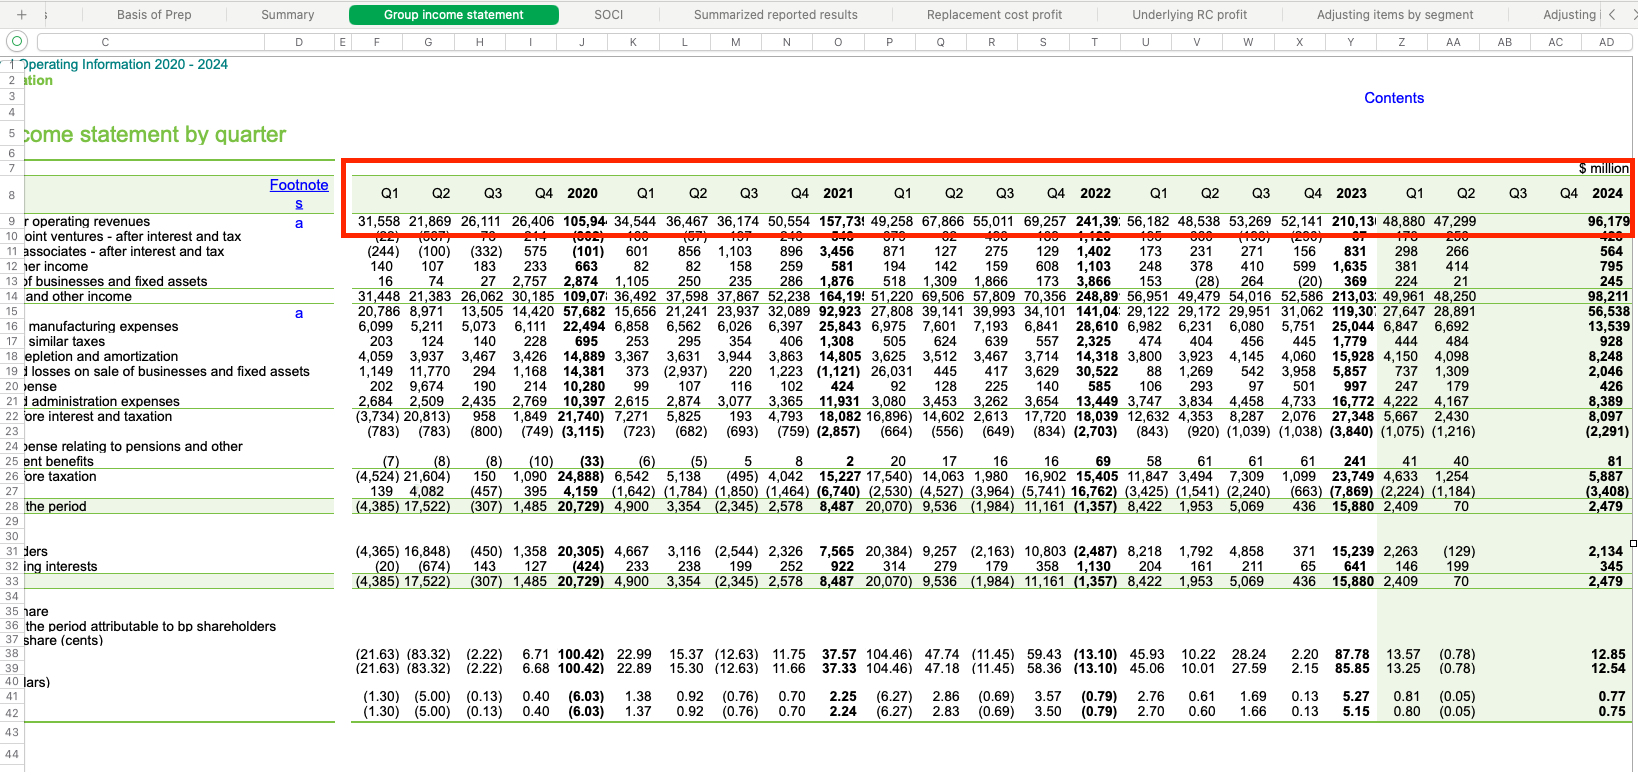

In [ ]:
# Reference page for query and answer

Image(filename="./references/query2.png")

Source node from which answer is generated.

In [ ]:
print(response_recursive_gpt4o_mini.source_nodes[1].get_content())

This table presents the financial and operating information of a group from 2020 to 2024, including quarterly income statements, revenues, expenses, and profit or loss figures.,
with the following table title:
Financial and Operating Information 2020 - 2024,
with the following columns:
- Group information: None
- Group income statement by quarter: None
- Sales and other operating revenues: None
- Earnings from joint ventures - after interest and tax: None
- Earnings from associates - after interest and tax: None
- Interest and other income: None
- Gains on sale of businesses and fixed assets: None
- Total revenues and other income: None
- Purchases: None
- Production and manufacturing expenses: None
- Production and similar taxes: None
- Depreciation, depletion and amortization: None
- Impairment and losses on sale of businesses and fixed assets: None
- Exploration expense: None
- Distribution and administration expenses: None
- Profit (loss) before interest and taxation: None
- Financ